# Handwritten Digit Recognition using Keras and TensorFlow

In this project, I will develop a deep learning model to achieve a near state-of-the-art performance on the MNIST handwritten dataset. I'm going to use Keras with TensorFlow.

### MNIST Dataset

This dataset was constructed from a number of scanned document datasets availabe from the National Institute of Standards and Technology (NIST). These images were normalized in size and centered. Each image is in a 28x28 square (784 pixels). 60,000 images were used to train a model and 10,000 were used to test it. Excellent results achieve a prediction error of 1%. State-of-the-art results are approximately 0.2% which could be achieved with a large convolutional neural network.

## Visualize Data

Here are some handwritten numbers from the dataset.

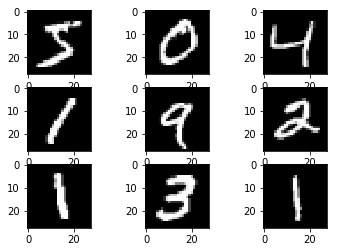

In [5]:
# Plot of images as baseline for comparison 
from keras.datasets import mnist 
from matplotlib import pyplot 
# load data 
(X_train, y_train), (X_test, y_test) = mnist.load_data() 
# create a grid of 3x3 images 
for i in range(0, 9): 
    pyplot.subplot(330 + 1 + i) 
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()

## Baseline Model with Multilayer Perceptrons

We start with a baseline model so we can compare our convolutional neural network that we will use later.

To do a multilayer perceptron model, we flatten our 28 by 28 pixel images into a single 784 length vector for each image.

We then change the grayscale values from 0-255 to 0-1 to make things easier on our neural network. (Normalization)

Finally, we change the categories 1-9 into a binary matrix.

Our current neural network structure is as follows:

**Visible Layer (784 Inputs) >> Hidden Layer (784 Neurons) >> Output Layer (10 Outputs)**

In [3]:
# Baseline MLP for MNIST dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
6s - loss: 0.2781 - acc: 0.9211 - val_loss: 0.1412 - val_acc: 0.9571
Epoch 2/10
6s - loss: 0.1115 - acc: 0.9678 - val_loss: 0.0921 - val_acc: 0.9705
Epoch 3/10
5s - loss: 0.0720 - acc: 0.9794 - val_loss: 0.0781 - val_acc: 0.9770
Epoch 4/10
6s - loss: 0.0506 - acc: 0.9856 - val_loss: 0.0744 - val_acc: 0.9768
Epoch 5/10
6s - loss: 0.0375 - acc: 0.9892 - val_loss: 0.0674 - val_acc: 0.9792
Epoch 6/10
6s - loss: 0.0270 - acc: 0.9926 - val_loss: 0.0622 - val_acc: 0.9810
Epoch 7/10
6s - loss: 0.0211 - acc: 0.9948 - val_loss: 0.0617 - val_acc: 0.9811
Epoch 8/10
6s - loss: 0.0142 - acc: 0.9968 - val_loss: 0.0624 - val_acc: 0.9802
Epoch 9/10
6s - loss: 0.0110 - acc: 0.9977 - val_loss: 0.0589 - val_acc: 0.9812
Epoch 10/10
5s - loss: 0.0082 - acc: 0.9984 - val_loss: 0.0573 - val_acc: 0.9824
Baseline Error: 1.76%


## Simple Convolutional Neural Network for MNIST

As expected, we achieved around 1-2% error which is great. However, we can do better. Here, we take advantage of Kera's capability of creating convolutional neural networks. We will use all aspects of a modern CNN implementation, including convolutional layers, pooling layers, and dropout layers.

Here are our changes for the baseline model:
1. We add a convolutional layer with 32 feature maps, with a size of 5 x 5. This is also our input layer which expects images to be added.
2. We then define a pool size of 2 x 2.
3. We randomly dropout 20% of our neurons to reduce the amount of overfitting.
4. We then flatten our data.
5. We add 128 neurons with a rectifer activation function like above.
6. Finally we use 10 neurons for the 10 prediction classes with a softmax activation function to output probability-like prediction for each class.

Our current neural network structure is as follows:

**Visible Layer (1x28x28 Inputs) >> Convolutional Layer (32 maps, 5x5) >> Max Pooling Layer (2x2) >> Dropout Layer (20%) >> Flatten Layer >> Hidden Layer (128 Neurons) >> Output Layer (10 Outputs)**

In [1]:
# Simple CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
# fix dimension ordering issue
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][channels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
# define a simple CNN model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Using TensorFlow backend.


11108352/11490434 [============================>.] - ETA: 0sTrain on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 108s - loss: 0.2320 - acc: 0.9344 - val_loss: 0.0818 - val_acc: 0.9738
Epoch 2/10
60000/60000 [==============================] - 114s - loss: 0.0736 - acc: 0.9782 - val_loss: 0.0462 - val_acc: 0.9840
Epoch 3/10
60000/60000 [==============================] - 114s - loss: 0.0532 - acc: 0.9841 - val_loss: 0.0438 - val_acc: 0.9860
Epoch 4/10
60000/60000 [==============================] - 108s - loss: 0.0403 - acc: 0.9878 - val_loss: 0.0403 - val_acc: 0.9872
Epoch 5/10
60000/60000 [==============================] - 108s - loss: 0.0336 - acc: 0.9894 - val_loss: 0.0344 - val_acc: 0.9884
Epoch 6/10
60000/60000 [==============================] - 108s - loss: 0.0275 - acc: 0.9915 - val_loss: 0.0307 - val_acc: 0.9896
Epoch 7/10
60000/60000 [==============================] - 107s - loss: 0.0235 - acc: 0.9928 - val_loss: 0.0352 - val

## Larger Convolutional Neural Network for MNIST

Here we achieved around 1% error which is excellent. However, we can hit state-of-the-art results. Here, we deepen and widen our neural network.

Our current neural network structure is as follows:

**Visible Layer (1x28x28 Inputs) >> Convolutional Layer (30 maps, 5x5) >> Max Pooling Layer (2x2) >> Convolutional Layer (15 maps, 3x3) >> Max Pooling Layer (2x2) >> Dropout Layer (20%) >> Hidden Layer (128 Neurons) >> Hidden Layer (50 Neurons) >> Output Layer (10 Outputs)**

In [2]:
# Larger CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
# define the larger model
def larger_model():
	# create model
	model = Sequential()
	model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Conv2D(15, (3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# build the model
model = larger_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 114s - loss: 0.3991 - acc: 0.8769 - val_loss: 0.1008 - val_acc: 0.9689
Epoch 2/10
60000/60000 [==============================] - 117s - loss: 0.0963 - acc: 0.9704 - val_loss: 0.0560 - val_acc: 0.9821
Epoch 3/10
60000/60000 [==============================] - 118s - loss: 0.0685 - acc: 0.9789 - val_loss: 0.0370 - val_acc: 0.9884
Epoch 4/10
60000/60000 [==============================] - 118s - loss: 0.0556 - acc: 0.9822 - val_loss: 0.0307 - val_acc: 0.9900
Epoch 5/10
60000/60000 [==============================] - 116s - loss: 0.0471 - acc: 0.9858 - val_loss: 0.0294 - val_acc: 0.9902
Epoch 6/10
60000/60000 [==============================] - 116s - loss: 0.0430 - acc: 0.9863 - val_loss: 0.0274 - val_acc: 0.9914
Epoch 7/10
60000/60000 [==============================] - 117s - loss: 0.0385 - acc: 0.9876 - val_loss: 0.0257 - val_acc: 0.9910
Epoch 8/10
60000/60000 [=======================

## Conclusion

With our ability to take advantage of larger convolutional neural network with Keras, we were able to go from 1-2% prediction error to less than 1%, near-state-of-the-art results! However, even with this model there are still further improvements which we can do with image augmentation and a much more powerful GPU.

### Baseline

These are the images that we used.

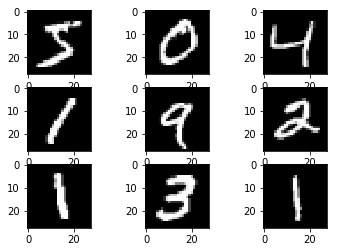

In [9]:
# Plot of images as baseline for comparison 
from keras.datasets import mnist 
from matplotlib import pyplot 
# load data 
(X_train, y_train), (X_test, y_test) = mnist.load_data() 
# create a grid of 3x3 images 
for i in range(0, 9): 
    pyplot.subplot(330 + 1 + i) 
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()

### Feature Standardization

Similar to different scalar values, we can standardize different images. The result that standardizing images brings is slightly darkening and lightening different images.

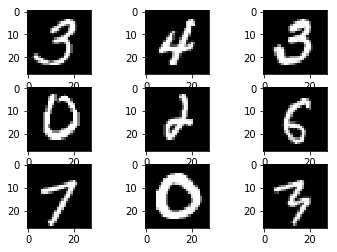

In [10]:
# Standardize images across the dataset, mean=0, stdev=1
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

### ZCA Whitening

Here, we reduce the redundancy of certain pixels in order to highlight certain features of images. Similar to principal component analysis, we use ZCA for images.

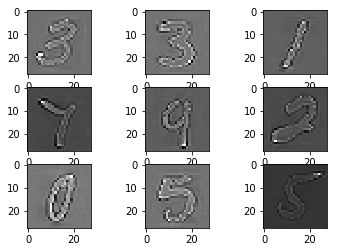

In [11]:
# ZCA whitening
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(zca_whitening=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

### Random Rotations

Different people write in different angles. Here we randomly rotate images up to 90 degrees.

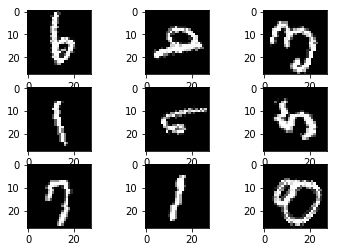

In [12]:
# Random Rotations
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(rotation_range=90)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

### Random Shifts

Sometimes numbers won't be exactly centered. Here we randomly shift numbers to be slightly off-centered.

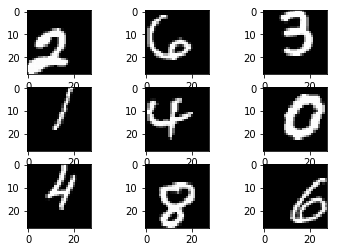

In [13]:
# Random Shifts
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break